In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet101, ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm.auto import trange, tqdm
from keras.utils import to_categorical

In [2]:
def create_dataset(img_folder):
   
    train_data=[]
    val_data=[]
    test_data=[]
    
    train_label=[]
    val_label=[]
    test_label=[]
   
    for dir1 in tqdm(os.listdir(img_folder)):
        for eye in os.listdir(os.path.join(img_folder, dir1)):
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [1, 3, 5, 6, 7, 9]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                train_data.append(img)
                train_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [0, 2, 8]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                val_data.append(img)
                val_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [4, 8]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                test_data.append(img)
                test_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
    return np.array(train_data), np.array(train_label), np.array(val_data), np.array(val_label), np.array(test_data), np.array(test_label)

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = create_dataset('CASIA-Iris-Thousand')

  0%|          | 0/1000 [00:00<?, ?it/s]

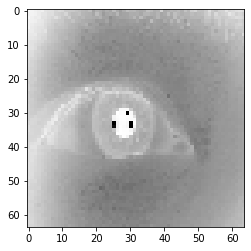

In [4]:
plt.imshow((X_train[0]*255).astype(np.uint8))

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(np.concatenate((X_train, X_val, X_test), axis=0), np.concatenate((y_train, y_val, y_test), axis=0), test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
np.save('temp_data/X_train.npy', X_train)
np.save('temp_data/X_val.npy', X_val)
np.save('temp_data/X_test.npy', X_test)

np.save('temp_data/y_train.npy', y_train)
np.save('temp_data/y_val.npy', y_val)
np.save('temp_data/y_test.npy', y_test)

In [57]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [58]:
# X_train = resnet_preprocess_input(X_train)
# X_val = resnet_preprocess_input(X_val)
# X_test = resnet_preprocess_input(X_test)

X_train = vgg16_preprocess_input(X_train)
X_val = vgg16_preprocess_input(X_val)
X_test = vgg16_preprocess_input(X_test)

In [59]:
le = LabelEncoder()

y_train = to_categorical(le.fit_transform(y_train), num_classes=2000)
y_val = to_categorical(le.fit_transform(y_val), num_classes=2000)
y_test = to_categorical(le.fit_transform(y_test), num_classes=2000)

In [60]:
# Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [61]:
with tf.device('GPU:0'):
    # Load the ResNet101 model with pre-trained weights on ImageNet dataset
    model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

    # Freeze the layers of the ResNet101 model
    for layer in model.layers:
        layer.trainable = False

    # Add custom layers on top of the ResNet101 model
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(512, activation='sigmoid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(2000, activation='softmax')(x)

    # Combine the ResNet101 model with the custom layers
    model = keras.models.Model(inputs=model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_val, y_val), verbose=1)

Epoch 1/40
750/750 [==============================] - 14s 17ms/step - loss: 6.6494 - accuracy: 0.0414 - val_loss: 4.6660 - val_accuracy: 0.1827
Epoch 2/40
750/750 [==============================] - 12s 16ms/step - loss: 3.8147 - accuracy: 0.2680 - val_loss: 2.9851 - val_accuracy: 0.3918
Epoch 3/40
750/750 [==============================] - 12s 16ms/step - loss: 2.2329 - accuracy: 0.5097 - val_loss: 2.2699 - val_accuracy: 0.5212
Epoch 4/40
750/750 [==============================] - 12s 16ms/step - loss: 1.4591 - accuracy: 0.6488 - val_loss: 2.0348 - val_accuracy: 0.5673
Epoch 5/40
750/750 [==============================] - 12s 16ms/step - loss: 1.0685 - accuracy: 0.7286 - val_loss: 1.8616 - val_accuracy: 0.6117
Epoch 6/40
750/750 [==============================] - 12s 16ms/step - loss: 0.8262 - accuracy: 0.7822 - val_loss: 1.7676 - val_accuracy: 0.6340
Epoch 7/40
750/750 [==============================] - 12s 16ms/step - loss: 0.7042 - accuracy: 0.8099 - val_loss: 1.7871 - val_accuracy:

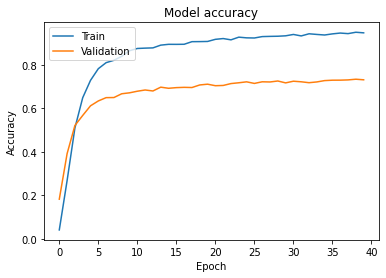

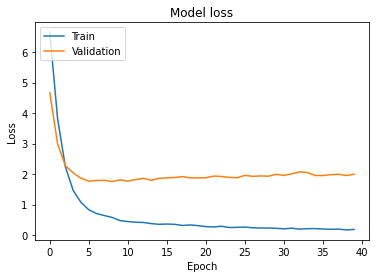

In [62]:
# Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [63]:
model.save('Model/VGG16_40.h5')

In [66]:
model = keras.models.load_model('Model/VGG16_40.h5')

125/125 [==============================] - 2s 15ms/step


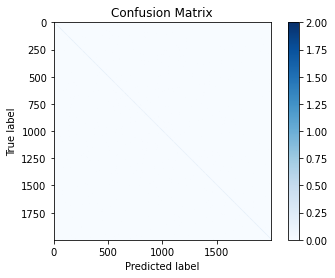

Accuracy: 75.92%


In [67]:
# Predict on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

# Plot the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))


In [25]:
import sklearn.svm as svm
import sklearn.model_selection as model_selection

In [22]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [23]:
with tf.device('GPU:0'):
    features_train = model.predict(X_train)
    features_val = model.predict(X_val)
    features_test = model.predict(X_test)

125/125 [==============================] - 2s 12ms/step


In [32]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [33]:
clf = svm.SVC(kernel='linear', C=1.0, probability=True)
clf.fit(features_train.reshape(features_train.shape[0], -1), y_train)

SVC(kernel='linear', probability=True)

In [37]:
predict = clf.predict(features_val.reshape(features_val.shape[0], -1))

In [38]:
accuracy = accuracy_score(predict, y_val)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 77.55%
